## Imports and setup

In [19]:
# Standard library imports
import os
import time

# Third-party imports for numerical operations and data handling
import numpy as np
import scipy.io

# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split

# PyTorch Lightning imports
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint

# Vision and image processing imports
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torchvision.ops.boxes as box_ops
from torchvision.transforms import Compose, Normalize, Resize, ToTensor
from torchvision.transforms.functional import to_pil_image

# Transformers (Hugging Face) imports
from transformers import ViTImageProcessor, ViTModel

In [20]:
start_time = time.time()

In [21]:
# Set CUDNN settings for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Optional: Set a random seed
seed = 2
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

## Prepare dataset

We use the [Caltech 101 Dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/).

In [22]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_dir, img_dir, transform=None, target_transform=None):
        self.img_paths = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.annotations_dir = annotations_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path)
        original_dim = image.size

        # Construct annotation file name based on image file name
        img_filename = os.path.basename(img_path)
        annotation_filename = 'annotation_' + img_filename.split('_')[1]  # Replace 'image_' with 'annotation_'
        annotation_file = os.path.splitext(annotation_filename)[0] + '.mat'

        bbox = scipy.io.loadmat(os.path.join(self.annotations_dir, annotation_file))["box_coord"][0]
        bbox_coord = (bbox[2], bbox[0], bbox[3], bbox[1])  # Reformat bbox_coord

        if self.transform:
            transformed_image = self.transform(image)
            bbox_coord = self.normalize_bbox(bbox_coord, original_dim)
        else:
            transformed_image = image

        return transformed_image, bbox_coord, img_path

    def normalize_bbox(self, bbox, img_dim):
        x_min, y_min, x_max, y_max = bbox
        width, height = img_dim
        return [x_min / width, y_min / height, x_max / width, y_max / height]

def show_image_with_bbox(tensor_image, bbox_coord, img_dim=None):
    # Convert tensor to PIL image
    pil_image = to_pil_image(tensor_image)

    if img_dim is None:
        # If image dimensions are not provided, infer them from the PIL image
        img_dim = pil_image.size

    # img_dim should contain width and height of the image
    img_width, img_height = img_dim

    # Convert normalized bbox coordinates back to pixel values
    pixel_bbox_coord = [
        bbox_coord[0] * img_width, 
        bbox_coord[1] * img_height, 
        bbox_coord[2] * img_width, 
        bbox_coord[3] * img_height
    ]

    draw = ImageDraw.Draw(pil_image)

    if isinstance(pixel_bbox_coord, (list, tuple)) and len(pixel_bbox_coord) == 4:
        # Draw the rectangle on the image
        draw.rectangle(pixel_bbox_coord, outline="red", width=2)
    else:
        raise ValueError("bbox_coord must be a list or tuple of 4 values")

    return pil_image

In [23]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)

img_transform = Compose([Resize((size, size)), ToTensor(), normalize])

In [24]:
# Path to images and annotations
img_dir = "C:/Users/regis/experiments/experiments/caltech-101/101_ObjectCategories/airplanes/"
annotations_dir = "C:/Users/regis/experiments/experiments/caltech-101/Annotations/Airplanes_Side_2/"

# Initialize dataset
dataset = CustomImageDataset(annotations_dir, img_dir, transform=img_transform)

In [25]:
# for i in range(5):
#     tensor_image, bbox_coord, _ = dataset[i]
#     show_image_with_bbox(tensor_image, bbox_coord).show()

In [26]:
# Define the sizes for your train, validation, and test sets
train_size = int(0.7 * len(dataset))  # 70% of dataset
val_size = int(0.15 * len(dataset))   # 15% of dataset
test_size = len(dataset) - (train_size + val_size)  # Remaining 15%

# If you want reproducibility, provide a generator to the random_split function
gen = torch.Generator()
gen.manual_seed(42)  # Set the random seed for reproducibility

# Split the dataset
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size], generator=gen)

In [27]:
def collate_fn(examples):
    pixel_values = torch.stack([example[0] for example in examples])

    bbox_coord = []
    for example in examples:
        if isinstance(example[1], list):
            bbox_coord.append(torch.tensor(np.array(example[1], dtype=np.float32), dtype=torch.float32))
        elif isinstance(example[1], np.ndarray):
            bbox_coord.append(torch.tensor(example[1].astype(np.float32), dtype=torch.float32))
        elif isinstance(example[1], tuple):
            bbox_coord.append(torch.tensor(np.array(example[1], dtype=np.float32), dtype=torch.float32))
        else:
            raise TypeError("Bounding box coordinates must be a list, tuple, or NumPy array")

    return {"pixel_values": pixel_values, "labels": torch.stack(bbox_coord)}


train_batch_size = 64
eval_batch_size = 64

# Create DataLoaders for training, validation, and testing
train_dataloader = DataLoader(train_ds, shuffle=True, collate_fn=collate_fn, batch_size=train_batch_size)
val_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=eval_batch_size)
test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=eval_batch_size)

## Define the model

In [28]:
# Define a LightningModule for the ViT model
class ViTLightningModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        
        # Unfreeze the last few layers of the ViT model
        for param in self.vit.parameters():
            param.requires_grad = False
        # for param in self.vit.encoder.layer[-2:].parameters():
        #     param.requires_grad = True

        hidden_units = [2048, 1024, 512, 256]  # Updated hidden units
        dropout_rate = 0.3  # Set the dropout rate

        # Create the custom head with dropout
        mlp_layers = []
        mlp_layers.append(nn.LayerNorm(self.vit.config.hidden_size, eps=1e-6))
        mlp_layers.append(nn.Flatten())

        in_features = self.vit.config.hidden_size
        for hidden_unit in hidden_units:
            mlp_layers.append(nn.Linear(in_features, hidden_unit))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(dropout_rate))  # Adding dropout here
            in_features = hidden_unit

        # Final linear layer
        mlp_layers.append(nn.Linear(hidden_units[-1], 4))
        mlp_layers.append(nn.Sigmoid())

        self.head = nn.Sequential(*mlp_layers)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        cls_token_state = outputs.last_hidden_state[:, 0, :]
        logits = self.head(cls_token_state)
        return logits
    
    def calculate_giou_loss(self, preds, targets):
        # Use Generalized IoU for loss calculation
        giou_loss = 1 - box_ops.generalized_box_iou(preds, targets).diag().mean()
        self.log("giou_loss", giou_loss, on_epoch=True)
        return giou_loss

    def common_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        logits = self(pixel_values)
        preds = logits  # Assuming bbox coordinates are normalized
        loss = self.calculate_giou_loss(preds, labels)
        return loss
      
    def training_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True),
            'monitor': 'validation_loss'  # Name of the metric to monitor
        }
        return [optimizer], [scheduler]

    def test_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx)     
        return loss

    def predict_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        logits = self(pixel_values)
        # Directly return the logits as predictions since they represent bounding box coordinates
        return logits

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

    def test_dataloader(self):
        return test_dataloader

    def predict_dataloader(self, dataloader):
        self.eval()  # Set the model to evaluation mode
        predictions = []
        with torch.no_grad():  # Disable gradient calculation
            for batch in dataloader:
                pixel_values = batch['pixel_values']
                logits = self(pixel_values)
                # Remove the argmax function and directly use the logits
                predictions.extend(logits.cpu().numpy())
        return predictions

## Initialize and Train the model

In [30]:
# Initialize the LightningModule
model = ViTLightningModule()

# Define an early stopping callback
early_stop_callback = EarlyStopping(
    monitor='validation_loss',
    patience=3,
    strict=False,
    verbose=False,
    mode='min'
)

device = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Initialize the PyTorch Lightning Trainer
trainer = Trainer(
    max_epochs=-1,
    log_every_n_steps=5,
    callbacks=[
        early_stop_callback,
        LearningRateMonitor(logging_interval='epoch'),
        ModelCheckpoint(
            dirpath='save/path/',
            save_top_k=1,
            monitor='validation_loss')
            ]
            )

# Train the model
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | vit  | ViTModel   | 86.4 M
1 | head | Sequential | 4.3 M 
------------------------------------
4.3 M     Trainable params
86.4 M    Non-trainable params
90.7 M    Total params
362.884   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Evaluation

In [31]:
# Get predictions on the test set
test_predictions = trainer.predict(model=model, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [32]:
# Collect the predicted labels from the test predictions
predictions_list = []
for tensor in test_predictions:
    numpy_array = tensor.cpu().numpy()
    predictions_list.extend(numpy_array)

# Convert the list of predicted labels to a NumPy array
predictions_array = np.array(predictions_list)

In [33]:
def calculate_giou(original_bbox, predicted_bbox):
    # Convert the bboxes to tensors and calculate GIoU
    original_bbox_tensor = torch.tensor(original_bbox).unsqueeze(0)
    predicted_bbox_tensor = torch.tensor(predicted_bbox).unsqueeze(0)
    giou = box_ops.generalized_box_iou(original_bbox_tensor, predicted_bbox_tensor)
    return giou[0, 0].item()

def display_images_with_bboxes(image_paths, predictions, original_bboxes):
    # Create subplots in a 3x4 grid pattern
    fig, axes = plt.subplots(4, 3, figsize=(16, 9))  # Adjust the figsize as needed

    # Flatten the axes array for easy iteration
    axes_flat = axes.flatten()

    for i, img_path in enumerate(image_paths):
        # Skip if the index is out of grid bounds
        if i >= 12:
            break

        original_img = Image.open(img_path)
        original_width, original_height = original_img.size

        # Scale the bounding box coordinates to the original image size
        scaled_pred_bbox = [predictions[i][0] * original_width,
                            predictions[i][1] * original_height,
                            predictions[i][2] * original_width,
                            predictions[i][3] * original_height]

        scaled_orig_bbox = [original_bboxes[i][0] * original_width,
                            original_bboxes[i][1] * original_height,
                            original_bboxes[i][2] * original_width,
                            original_bboxes[i][3] * original_height]

        # Draw both bounding boxes
        draw = ImageDraw.Draw(original_img)
        draw.rectangle(scaled_orig_bbox, outline="green", width=2)
        draw.rectangle(scaled_pred_bbox, outline="red", width=2)

        # Calculate and print GIoU loss
        giou_loss = calculate_giou(scaled_orig_bbox, scaled_pred_bbox)
        axes_flat[i].set_title(f"GIoU Loss: {giou_loss:.4f}")

        axes_flat[i].imshow(original_img)
        axes_flat[i].axis('off')

    # Hide any unused axes
    for j in range(i + 1, 12):
        axes_flat[j].axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()

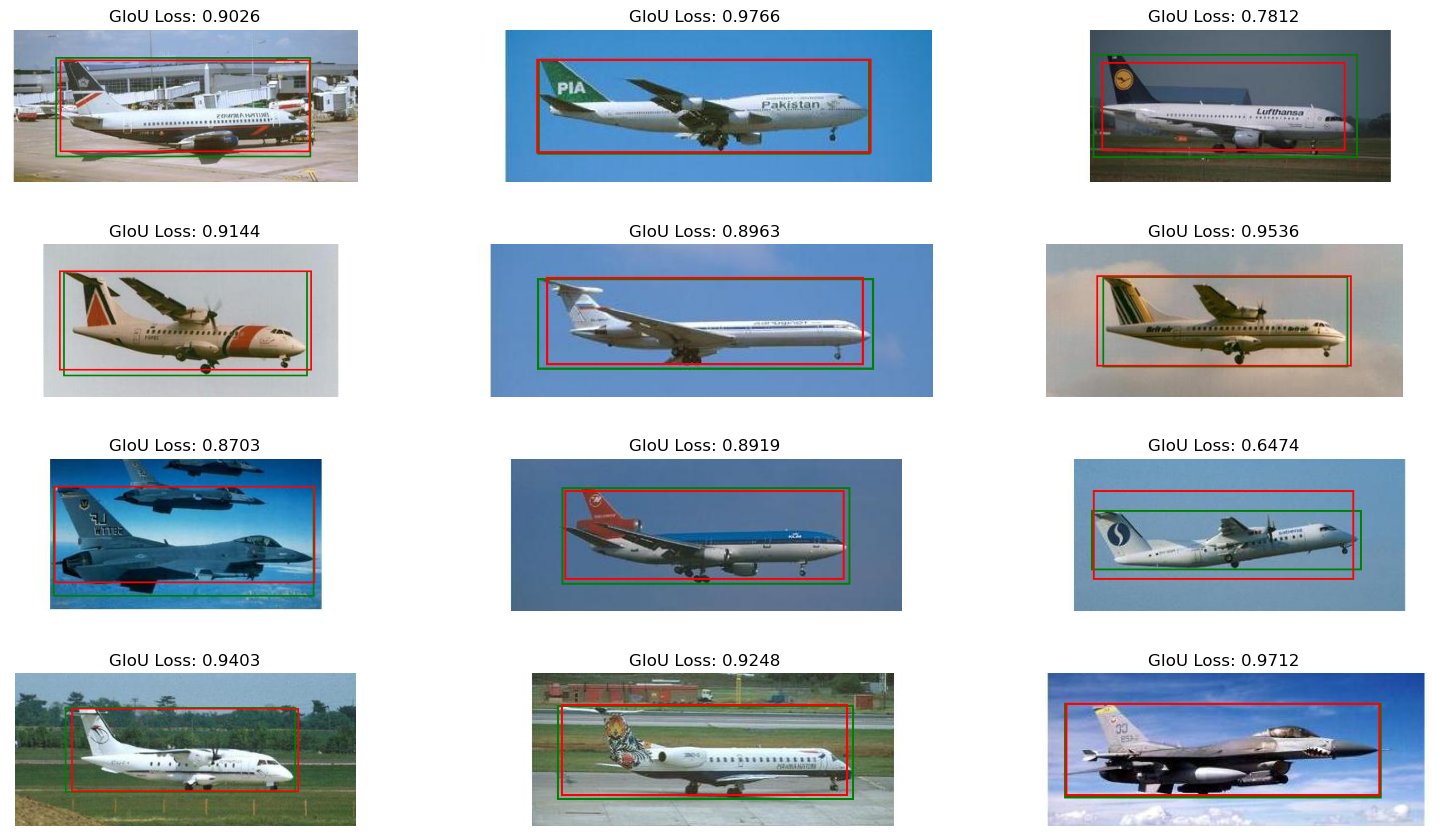

In [34]:
test_image_paths = [test_ds.dataset.img_paths[i] for i in test_ds.indices]

num_images_to_display = 12  # Set the number of images you want to display

original_bboxes = [dataset[i][1] for i in test_ds.indices]  # Extracting original bboxes from the test dataset

display_images_with_bboxes(
    test_image_paths[:num_images_to_display],
    predictions_array[:num_images_to_display],
    original_bboxes[:num_images_to_display]
    )

In [35]:
# Assuming you have a list of predictions and corresponding original bboxes
predictions_list = predictions_array  # Replace with your predictions list
original_bboxes_list = [dataset[i][1] for i in range(len(dataset))]  # Replace with your original bboxes list

giou_values = []
for original_bbox, predicted_bbox in zip(original_bboxes_list, predictions_list):
    # Scale bboxes as required by your application
    scaled_orig_bbox = [original_bbox[0], original_bbox[1], original_bbox[2], original_bbox[3]]
    scaled_pred_bbox = [predicted_bbox[0], predicted_bbox[1], predicted_bbox[2], predicted_bbox[3]]

    giou = calculate_giou(scaled_orig_bbox, scaled_pred_bbox)
    giou_values.append(giou)

# Calculating min, max, and average GIoU
min_giou = min(giou_values)
max_giou = max(giou_values)
average_giou = sum(giou_values) / len(giou_values)

print(f"Min GIoU: {min_giou}")
print(f"Max GIoU: {max_giou}")
print(f"Average GIoU: {average_giou}")

Min GIoU: -5.485269396948736e-08
Max GIoU: 0.9675213860763464
Average GIoU: 0.8296749081605257


In [36]:
# Calculate and print the total runtime
print(f'Total runtime: {np.round((time.time()-start_time) / 60, 2)} minutes')

Total runtime: 1.2 minutes
